# Gaining Insights from Sales Data

Here we use the UCI Online Retail dataset to gain customer insights

In [1]:
# Import libraries
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

First, we import the data

In [2]:
cd

C:\Users\leahy


In [3]:
data = pd.read_csv('google drive/freelance/own projects/customer_dataset/online_retail_data.csv', encoding='utf-8', dayfirst=True)

Now, let's have a quick look at this to see what the data looks like

In [4]:
print(data.dtypes)
data.head()

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


Let's make the data column headers `snake_case` to make them easier to work with, and convert the dates to `datetime` object

In [5]:
data.columns = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
data.invoice_date = pd.to_datetime(data.invoice_date, dayfirst=True)
data.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Cohort Analysis
Let's break our customers into different cohorts based on the month they made their first purchase.

First, we need to create a separate column, `invoice_month`, in which we get the month of the invoice.

In [6]:
data['invoice_month'] = data['invoice_date'].dt.to_period('M').dt.to_timestamp()

Next, we group by `customer_id` and apply a transformation to find the lowest `invoice_month` for each. We store this in the `cohort_month` column.

In [7]:
data['cohort_month'] = data.groupby('customer_id')['invoice_month'].transform('min')

Looks like there are a lot less `customer_id` than the others - probably NA values.

Let's drop these.


In [8]:
data = data.dropna()
data.shape

(406829, 10)

Next, we want to get the number of months between their first purchase and their current purchase. We'll call this the `cohort_index`.

Note that we add a "+1" to the difference between the months so that 0's are more easily interpretable.

In [9]:
data['cohort_index'] = pd.Series(((data.invoice_month - data.cohort_month) / np.timedelta64(1, 'M')).astype(int) + 1)

Next, we group the data by `cohort_month` and `cohort_index`, and see how many unique `customer_id`s are in each:

In [10]:
cohort_data = data.groupby(['cohort_month', 'cohort_index'])['customer_id'].apply(pd.Series.nunique).reset_index()
cohort_data

,cohort_month,cohort_index,customer_id
0,2010-12-01,1,948
1,2010-12-01,2,362
2,2010-12-01,3,482
3,2010-12-01,4,341
4,2010-12-01,5,376
...,...,...,...
75,2011-10-01,1,352
76,2011-10-01,2,93
77,2011-10-01,3,46
78,2011-11-01,1,321


In [44]:
cohort_data[(cohort_data.cohort_month == pd.Timestamp('01 apr 2011')) & (cohort_data.cohort_index == 2)]

,cohort_month,cohort_index,customer_id


Let's pivot this into a more useful format, by using the `cohort_month`s as an index against `cohort_index` as the columns, with the number of `customer_id`s in each as the values.

In [11]:
cohort_counts = cohort_data.pivot(index='cohort_month',
                                  columns='cohort_index',
                                  values='customer_id')
cohort_counts

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2010-12-01,948.0,362.0,482.0,341.0,376.0,360.0,336.0,336.0,NaN,510.0,NaN,538.0
2011-01-01,421.0,171.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02-01,380.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03-01,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN
2011-04-01,299.0,NaN,111.0,NaN,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN
2011-05-01,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN
2011-06-01,235.0,NaN,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN
2011-07-01,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This gives us a useful table to store the data in.

From here, we can continue to our three different types of cohort analysis, presented in easy to read graphics.

## Customer Retention Rate
To see the percentage of customers we retain each month.

In [14]:
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.index = retention.index.to_period('M')

(13.0, 0.0)

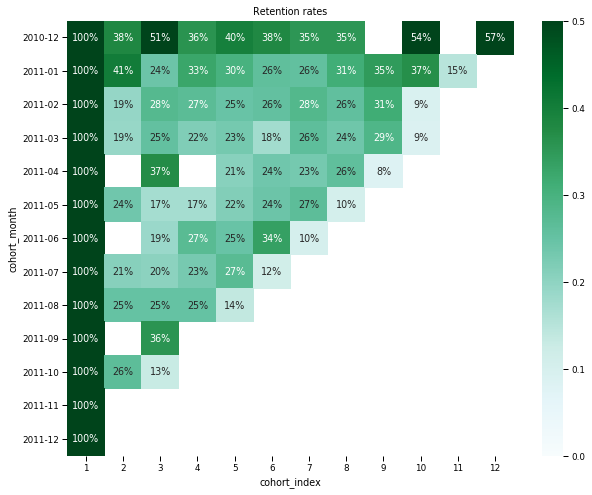

In [35]:
plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.set_context('paper')
sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0, vmax=0.5, cmap='BuGn')
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)

## Average qty purchased per cohort

(13.0, 0.0)

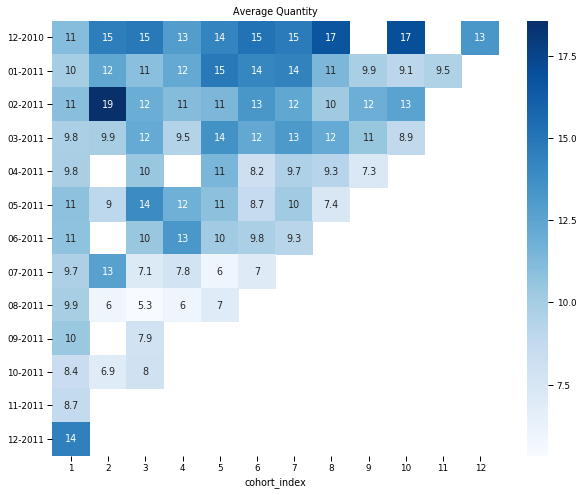

In [36]:
grouping_qty = data.groupby(['cohort_month', 'cohort_index'])
cohort_data_qty = grouping_qty['quantity'].mean()
cohort_data_qty = cohort_data_qty.reset_index()
average_quantity = cohort_data_qty.pivot(index='cohort_month',
                                     columns='cohort_index',
                                     values='quantity')
average_quantity.index = average_quantity.index.strftime('%m-%Y')
plt.figure(figsize=(10, 8))
plt.title('Average Quantity')
sns.heatmap(data = average_quantity, annot=True, cmap='Blues')
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)

## Average price of products purchased by each cohort

(13.0, 0.0)

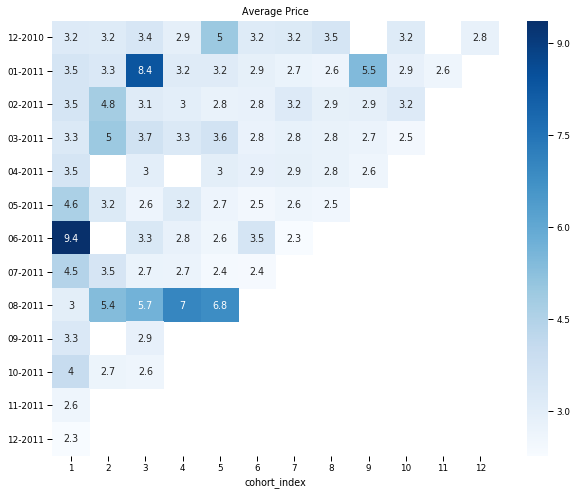

In [45]:
# --Calculate Average Price--
grouping_price = data.groupby(['cohort_month', 'cohort_index'])
cohort_data_price = grouping_price['unit_price'].mean()
cohort_data_price = cohort_data_price.reset_index()
average_price = cohort_data_price.pivot(index='cohort_month',
                                     columns='cohort_index',
                                     values='unit_price')
average_price.index = average_price.index.strftime('%m-%Y')

plt.figure(figsize=(10, 8))
plt.title('Average Price')
sns.heatmap(data = average_price, annot=True, cmap='Blues')
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)